In [476]:
!mv /Users/camerondavidson-pilon/Downloads/*.dump.gz ..

(B

In [477]:
!gzip -f -d ../*.dump.gz

(B

In [478]:
!rm ../morbidostat.db
!sqlite3 ../morbidostat.db < ../od_readings_raw.dump
!sqlite3 ../morbidostat.db < ../io_events.dump

(B(B(B

In [722]:
import pandas as pd
import sqlite3
con = sqlite3.connect("../morbidostat.db")
experiment = "Trial-6-fc25fd2e44af4255bcb61d4f574f0087"
unit = 2
df = pd.read_sql_query(f'SELECT * from od_readings_raw WHERE experiment="{experiment}" and morbidostat_unit="{unit}"', con)
io_events = pd.read_sql_query(f'SELECT * from io_events WHERE experiment="{experiment}" and morbidostat_unit="{unit}"', con)

In [723]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index("timestamp")

io_events['timestamp'] = pd.to_datetime(io_events['timestamp'])
io_events = io_events.set_index("timestamp")


In [724]:
df = df.loc["2020-09-18 14:00:00":]

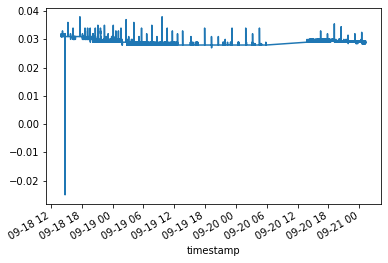

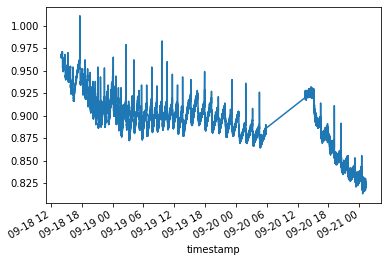

In [725]:
for _, g in df.loc["2020-09-18 9:00:00":].groupby("angle")['od_reading_v']:
    plt.figure()
    g.plot()

In [726]:
df.index = df.index.round('S')

In [727]:
df.shape

(73762, 4)

In [728]:
df_ = df.loc[df.groupby(level=0).size() == 2]

In [729]:
df_.shape

(68172, 4)

In [730]:
class ExtendedKalmanFilter:
    """
    Based on the algorithm in
    https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0181923#pone.0181923.s007

    The idea is that each sensor will evolve like:

    OD_{i, t+1} = OD_{i, t} * r_t

    for all i, t.

    This model is pretty naive (different sensors will behave / saturate differently).

    Example
    ---------

        initial_state = np.array([obs.iloc[0], 1.])
        initial_covariance = np.eye(2)
        process_noise_covariance = np.array([[0.00001, 0], [0, 1e-13]])
        observation_noise_covariance = 0.2
        ekf = ExtendedKalmanFilter(initial_state, initial_covariance, process_noise_covariance, observation_noise_covariance)

        ekf.update(...)
        ekf.state_

    """

    def __init__(self, initial_state, initial_covariance, process_noise_covariance, observation_noise_covariance):
        assert initial_state.shape[0] == initial_covariance.shape[0] == initial_covariance.shape[1]
        assert process_noise_covariance.shape == initial_covariance.shape
        assert self._is_positive_definite(process_noise_covariance)
        assert self._is_positive_definite(initial_covariance)

        self._process_noise_covariance = process_noise_covariance
        self.observation_noise_covariance = observation_noise_covariance
        self.state_ = initial_state
        self.covariance_ = initial_covariance
        self.dim = self.state_.shape[0]

        self._counter = -1
        self._original_process_noise_variance = self._process_noise_covariance[np.arange(d - 1), np.arange(d - 1)].copy()

    def predict(self):
        return (self._predict_state(self.state_, self.covariance_), self._predict_covariance(self.state_, self.covariance_))

    def update(self, observation):
        # TODO: incorporate delta_time
        state_prediction, covariance_prediction = self.predict()
        residual_state = observation - state_prediction[:-1]
        H = self._jacobian_observation()
        residual_covariance = H @ covariance_prediction @ H.T + self.observation_noise_covariance
        kalman_gain = covariance_prediction @ H.T @ np.linalg.inv(residual_covariance)
        self.state_ = state_prediction + kalman_gain @ residual_state
        self.covariance_ = (np.eye(self.dim) - kalman_gain @ H) @ covariance_prediction
        return

    def scale_OD_variance_for_next_n_steps(self, factor, n):
        d = self.dim
        self._counter = n
        self._process_noise_covariance[np.arange(d - 1), np.arange(d - 1)] = factor * self._original_process_noise_variance

    def process_noise_covariance(self):
        if self._counter == 0:
            d = self.dim
            self._process_noise_covariance[np.arange(d - 1), np.arange(d - 1)] = self._original_process_noise_variance
        self._counter -= 1
        return self._process_noise_covariance

    def _predict_state(self, state, covariance):
        return np.array([v * state[-1] for v in state[:-1]] + [state[-1]])

    def _predict_covariance(self, state, covariance):
        return self._jacobian_process(state) @ covariance @ self._jacobian_process(state).T + self.process_noise_covariance()

    def _jacobian_process(self, state):
        """
        The prediction process is
        [
            OD_{1, t+1} = OD_{1, t} * r_t
            OD_{2, t+1} = OD_{2, t} * r_t
            ...
            r_{t+1} = r_t

        ]

        """
        d = self.dim
        J = np.zeros((d, d))

        rate = state[-1]
        ODs = state[:-1]

        J[np.arange(d - 1), np.arange(d - 1)] = rate
        J[np.arange(d - 1), np.arange(1, d)] = ODs
        J[-1, -1] = 1.0

        return J

    def _jacobian_observation(self):
        """
        We only observe the ODs
        """
        d = self.dim
        return np.eye(d)[: (d - 1)]

    @staticmethod
    def _is_positive_definite(A):
        if np.array_equal(A, A.T):
            try:
                return True
            except np.linalg.LinAlgError:
                return False
        else:
            return False


In [731]:
df_.head(2)

,morbidostat_unit,od_reading_v,experiment,angle
timestamp,,,,
2020-09-18 14:00:03+00:00,2,0.965029,Trial-6-fc25fd2e44af4255bcb61d4f574f0087,135
2020-09-18 14:00:03+00:00,2,0.031001,Trial-6-fc25fd2e44af4255bcb61d4f574f0087,90


In [738]:
initial_state = np.array([0.029001, 0.926007, 1.0000])
d = initial_state.shape[0]

# empirically picked constants
initial_covariance = np.diag([1e-3] * (d - 1) + [1e-8])

OD_covariance = 1e-10 * np.ones((d-1, d-1))
OD_covariance[0, 0] = 1e-7
OD_covariance[1, 1] = 1e-5
process_noise_covariance = np.block([
    [OD_covariance,  1e-12 * np.ones((d-1, 1))],
    [1e-12 * np.ones((1, d-1)),  1e-12 ]
])

observation_noise_covariance = np.array([[1e-3, 0], [0, 1e-2]]) # this is a function of the ADS resolution at a gain
ekf = ExtendedKalmanFilter(
    initial_state, initial_covariance, process_noise_covariance, observation_noise_covariance,
)

In [739]:
results = []
try:
    obs_and_io = df_.merge(io_events, how="outer", right_index=True, left_index=True).sort_index()
except:
    obs_and_io = df_

for _, g in obs_and_io.groupby(level=0):
    if g.shape[0] == 1:
        ekf.scale_OD_variance_for_next_n_steps(1e2, 100)
    elif g.shape[0] == 2:
        ekf.update(g.sort_values("angle")['od_reading_v'].values)
        results.append(ekf.state_)
    else:
        pass
        
results = pd.DataFrame(results, columns=['90', '135',  'rate'])

<AxesSubplot:>

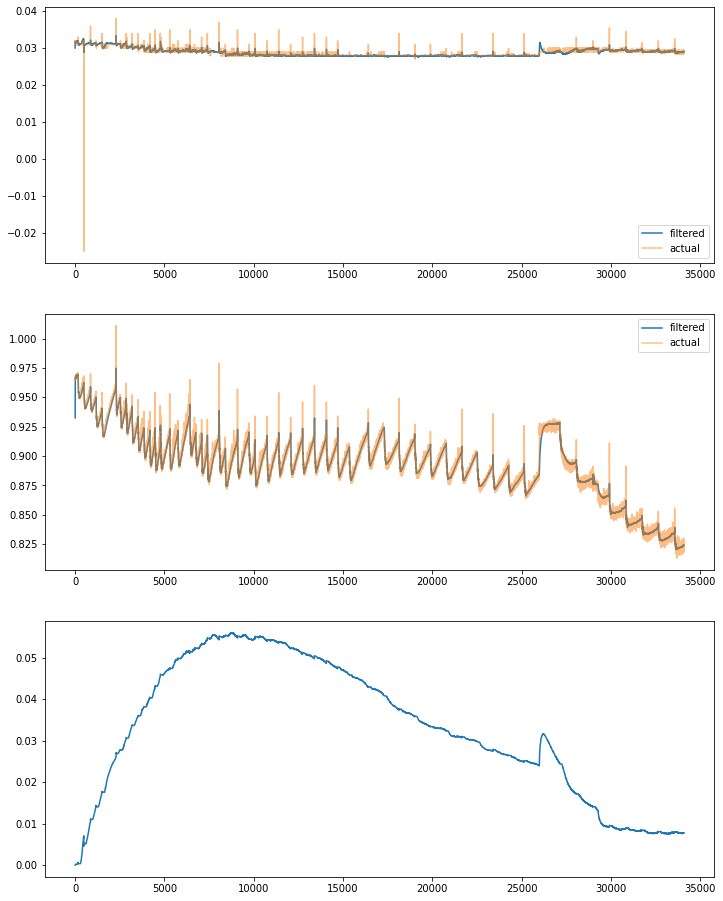

In [740]:
f, axes = plt.subplots(3, 1, figsize=(12, 16))


results['90'].plot(label="filtered", ax=axes[0])
axes[0].plot(df_.loc[df_['angle'] == 90]['od_reading_v'].values, alpha=0.5, label="actual")
axes[0].legend()

results['135'].plot(label="filtered", ax=axes[1])
axes[1].plot(df_.loc[df_['angle'] == 135]['od_reading_v'].values, alpha=0.5, label="actual")
axes[1].legend()

(np.log(results['rate'])*60*60*0.2).plot(ax=axes[2])
